### Import the packages

In [1]:
# import packages
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import winsound
import scipy.stats as stt
import networkx as nx 
import random

from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d

# Functions

Define the functions that we will be using later

In [2]:
# normalize a vector between 0 and 1 
def normalize01(vec):
    
    vec = np.array(vec)
    
    m = min(vec)
    M = max(vec)
    
    vec2 = (vec-m)/(M-m)
    
    return vec2

In [3]:
# find the array element which is the closest to value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [4]:
# Run the deffuant model for T steps.
# eps and mu are the classical model's parameters
# if scale=None then it does not reconvert to the original scale
def run_deffuant5(serie,T,eps,mu,scale=None, min_spacing=None):
    
    if min_spacing==None and type(scale)!=type(None):
        min_spacing = min(np.abs(scale[1:]-scale[0:-1]))
        
    if type(scale)==type(None) and min_spacing==None:
        raise Exception("scale==None and min_spacing==None")
    
    if not ((eps == 0) or (mu == 0)): # if one of them is zero just do nothing 

        l = len(serie)
        serie = np.array(serie)

        last_update = 0
        
        counter = 0
        while counter < T:
            # Get the indeces of the agents that will interact
            k1 = int(np.random.rand()*l)
            finito = False

            while not finito:
                k2 = int(np.random.rand()*l)
                if k1 != k2:
                    finito = True

            v1 = serie[k1]
            v2 = serie[k2]
            
            dist =np.abs(v1-v2)

            if (dist<=eps) and dist>min_spacing/2:
                last_update = 0

                vv1 = (1-mu)*v1 + mu*v2
                vv2 = (1-mu)*v2 + mu*v1

                serie[k1] = vv1
                serie[k2] = vv2
                
            last_update += 1
            
            if last_update > 2*len(serie): # check if it converged
                break
            
        if to_origin_scale == True:
            if not type(scale)==type(None):
                for i, el in enumerate(serie): # Bring them back to the scale
            #         print(i)
                    u = find_nearest(scale, el)
            #         print(u)
                    serie[i] = u        
        
    return serie

In [5]:
# smoothen the curve y. the bigger the range r the smoother the curve
def smoothen_curve(y,r):
    y = np.array(y)
    
    y2 = []
    for i, yi in enumerate(y):
        
        i_m = max([i-r,0])
        i_M = min([i+r,len(y)])
        
        mean = np.mean(y[i_m:i_M])
        
        y2.append(mean)
        
    y2 = np.array(y2)
    
    return y2


In [6]:
# theil's inequality coefficient
def theil(x,y):
    x = np.array(x)
    y = np.array(y)
    
    d = x-y
    
    num = np.sqrt(np.mean(d**2))
    den1 = np.sqrt(np.mean(x**2))
    den2 = np.sqrt(np.mean(y**2))
    
    t = num/(den1+den2)
    
    return t

In [7]:
def make_unique_hist(serie):
    serie = np.array(serie)
    
    unique = np.array(sorted(list(set(serie.copy()))))
    unique = unique.astype(float)
    
    hist = []
    for u in unique:
        sum_ = np.sum(serie == u)
        hist.append(sum_)
        
    hist = np.array(hist)
    
    return hist
    

In [8]:
# force the data on a scale (i.e. finds the nearest neighbor on that scale)
def force_on_scale(data,scale):

    for i,el in enumerate(data):
        data[i] = find_nearest(scale, el)
        
    return data

In [9]:
# Calculate the prediction error
def get_error2(x,y):
    
    err = theil(x,y)
    
    return err
    

In [10]:
# produce h (i.e. the distortion curve)
def make_dist_curve(exp_min = 1/3, exp_max = 3, prb_averaging = 0.3):
    dist_curve0 = make_init_distrib(n_points_init_distrib=4, 
                                          SET_BORDERS_ZERO = False, r_smooth = 15, N_bins0 = N_bins0)

    exp_ = np.random.rand()*(exp_max-exp_min)+exp_min

    dist_curve1 = np.cumsum(dist_curve0)
    dist_curve1 = dist_curve1/max(dist_curve1)
    dist_curve1 = dist_curve1**(exp_) #
    # lin_curve = x

    if np.random.rand()<prb_averaging:
        dist_curve1 = (dist_curve1+x)/2
        if np.random.rand()<prb_averaging:
            dist_curve1 = (dist_curve1+x)/2
    else:
        if np.random.rand()<prb_averaging:
            dist_curve1 = dist_curve1**2
            if np.random.rand()<prb_averaging:
                dist_curve1 = dist_curve1**4

    non_linearity = np.sum(np.abs(dist_curve1-x))/np.sum(x)
    
    return [dist_curve1, non_linearity]


In [11]:
# make the initial distribution
def make_init_distrib(n_points_init_distrib=4, SET_BORDERS_ZERO = True, r_smooth = 15, N_bins0 = 101):

    x0_d = sorted(np.random.rand(n_points_init_distrib))
    y0_d = np.random.rand(n_points_init_distrib)

    x = np.array(range(N_bins0))/(N_bins0-1)
    x0_d[0] = 0
    x0_d[-1] = 1

    if SET_BORDERS_ZERO:
        y0_d[0] = 0
        y0_d[-1] = 0

    X_Y_Spline = make_interp_spline(x0_d, y0_d)
    yy2 = X_Y_Spline(x)

    y0_d = normalize01(y0_d)
    yy2 = normalize01(yy2)

    return yy2

In [12]:
# initialize the probability values for the distribution function
def initialize_prb(x, N_pep, prb_curve):

    # Make the distrib of people
    index = range(0,len(x))

    opinions = []

    for i in range(0,N_pep): #for each person

        found = False
        while not found:
            I = random.choice(index)

            p = prb_curve[I]
            r = np.random.rand()

            if p>=r:
                found = True
                xi = x[I]
                opinions.append(xi)

    op0 = np.array(opinions)
    
    return op0

In [13]:
def beep(): # makes beep!
    freq = 500
    dur = 200
    winsound.Beep(freq, dur)
    return

In [14]:
# Transforms data according to the new scale
def transfor_data(data_line, curve, scale_orig):
    min_ = np.min(scale_orig)
    max_ = np.max(scale_orig)
    
    # renormalize as an index for curve
    data_std = (np.round((data_line-min_)/(max_-min_)*(len(curve)-1))).astype(int)
    
    data_std2 = data_std.copy().astype(float)*0
    
    for i,el in enumerate(data_std):
        data_std2[i] = curve[el]
        
    # renormalize for scale orig
    data_std2 = (data_std2*(max_-min_))+min_
    
    return data_std2

# Make the analysis

This is the section where we analyze the deffuant model for the different types of error

### Initial distribution

Showcase some instances of the initial distribution. The blue points are the ones that are used for fitting the distribution

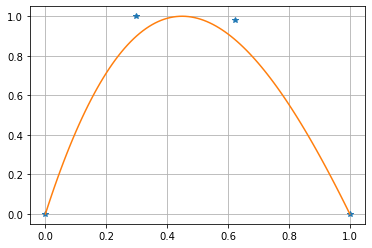

In [15]:
# Make the initial distribution
n_points_init_distrib = 4 # how many points to use for fitting the distribution
SET_BORDERS_ZERO = True # Set the extreme to 0 and 1
r_smooth = 15 # smoothening value

N_bins0 = 101

x0_d = sorted(np.random.rand(n_points_init_distrib))
y0_d = np.random.rand(n_points_init_distrib)

x = np.array(range(N_bins0))/(N_bins0-1)
x0_d[0] = 0
x0_d[-1] = 1

if SET_BORDERS_ZERO:
    y0_d[0] = 0
    y0_d[-1] = 0

X_Y_Spline = make_interp_spline(x0_d, y0_d)
yy2 = X_Y_Spline(x)

y0_d = normalize01(y0_d)
yy2 = normalize01(yy2)

plt.plot(x0_d,y0_d,'*')
# plt.plot(x,yy)
plt.plot(x,yy2)
plt.grid()



### Effect of Noise

How random noise affect the prediction error

### Run the model

...and collect the data for every value of noise

In [16]:
N_pep = 200 # in the article this is Na (i.e. the number of people/agents)
N_bins0 = 101 # Number of levels in the scale

# Time parameters
UNTIL_CONVERGENCE=False # Run the model until convergence
T_FIXED = False # Use the same T for each run
t_max = 5 # this is the maximum Tr 

to_origin_scale = False
mean_error = 0.054 

# How many values to try
N_repetitions = 1000 # Number of runs

# Initialize vectors
noi_vec = []
err2_vec = []

for jj in range(0, N_repetitions): # for each repetition
    print(jj, " out of ", N_repetitions)

    noise = np.random.rand()
    eps=np.random.rand()
    mu=np.random.rand()*0.5
    
    if UNTIL_CONVERGENCE:
        T = np.inf
    elif T_FIXED:
        T = N_pep*t_max
    else:
        T = N_pep*t_max*np.random.rand()
        

    x = np.array(range(N_bins0))/(N_bins0-1)

    distrib_curve = make_init_distrib(n_points_init_distrib=4, 
                                      SET_BORDERS_ZERO = False, r_smooth = 15, N_bins0 = 101)

    op0 = initialize_prb(x, N_pep, distrib_curve)

    op_dist = op0+ np.random.normal(loc=0.0, scale=noise) # gaussian noise
    
    
    op_dist[op_dist < 0] = 0
    op_dist[op_dist > 1] = 1

    op0_2 = run_deffuant5(op0,T=T,eps=eps,mu=mu,scale=x)
    op_dist_2 = run_deffuant5(op_dist,T=T,eps=eps,mu=mu,scale=x)
    
    err2 = get_error2(op0_2,op_dist_2)
    
    noi_vec.append(noise)
    err2_vec.append(err2)
    
noi_vec = np.array(noi_vec)
err2_vec = np.array(err2_vec)

0  out of  1000
1  out of  1000
2  out of  1000
3  out of  1000
4  out of  1000
5  out of  1000
6  out of  1000
7  out of  1000
8  out of  1000
9  out of  1000
10  out of  1000
11  out of  1000
12  out of  1000
13  out of  1000
14  out of  1000
15  out of  1000
16  out of  1000
17  out of  1000
18  out of  1000
19  out of  1000
20  out of  1000
21  out of  1000
22  out of  1000
23  out of  1000
24  out of  1000
25  out of  1000
26  out of  1000
27  out of  1000
28  out of  1000
29  out of  1000
30  out of  1000
31  out of  1000
32  out of  1000
33  out of  1000
34  out of  1000
35  out of  1000
36  out of  1000
37  out of  1000
38  out of  1000
39  out of  1000
40  out of  1000
41  out of  1000
42  out of  1000
43  out of  1000
44  out of  1000
45  out of  1000
46  out of  1000
47  out of  1000
48  out of  1000
49  out of  1000
50  out of  1000
51  out of  1000
52  out of  1000
53  out of  1000
54  out of  1000
55  out of  1000
56  out of  1000
57  out of  1000
58  out of  1000
59  out

461  out of  1000
462  out of  1000
463  out of  1000
464  out of  1000
465  out of  1000
466  out of  1000
467  out of  1000
468  out of  1000
469  out of  1000
470  out of  1000
471  out of  1000
472  out of  1000
473  out of  1000
474  out of  1000
475  out of  1000
476  out of  1000
477  out of  1000
478  out of  1000
479  out of  1000
480  out of  1000
481  out of  1000
482  out of  1000
483  out of  1000
484  out of  1000
485  out of  1000
486  out of  1000
487  out of  1000
488  out of  1000
489  out of  1000
490  out of  1000
491  out of  1000
492  out of  1000
493  out of  1000
494  out of  1000
495  out of  1000
496  out of  1000
497  out of  1000
498  out of  1000
499  out of  1000
500  out of  1000
501  out of  1000
502  out of  1000
503  out of  1000
504  out of  1000
505  out of  1000
506  out of  1000
507  out of  1000
508  out of  1000
509  out of  1000
510  out of  1000
511  out of  1000
512  out of  1000
513  out of  1000
514  out of  1000
515  out of  1000
516  out o

917  out of  1000
918  out of  1000
919  out of  1000
920  out of  1000
921  out of  1000
922  out of  1000
923  out of  1000
924  out of  1000
925  out of  1000
926  out of  1000
927  out of  1000
928  out of  1000
929  out of  1000
930  out of  1000
931  out of  1000
932  out of  1000
933  out of  1000
934  out of  1000
935  out of  1000
936  out of  1000
937  out of  1000
938  out of  1000
939  out of  1000
940  out of  1000
941  out of  1000
942  out of  1000
943  out of  1000
944  out of  1000
945  out of  1000
946  out of  1000
947  out of  1000
948  out of  1000
949  out of  1000
950  out of  1000
951  out of  1000
952  out of  1000
953  out of  1000
954  out of  1000
955  out of  1000
956  out of  1000
957  out of  1000
958  out of  1000
959  out of  1000
960  out of  1000
961  out of  1000
962  out of  1000
963  out of  1000
964  out of  1000
965  out of  1000
966  out of  1000
967  out of  1000
968  out of  1000
969  out of  1000
970  out of  1000
971  out of  1000
972  out o

##### Plot the data

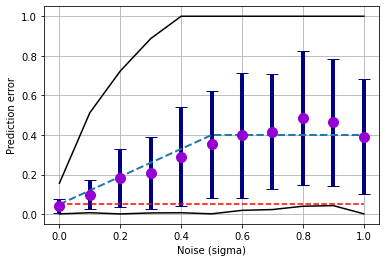

In [17]:
dn = 0.1
n_x = np.arange(0,1+dn,dn)

n_xb = (n_x[1:]+n_x[0:-1])/2

n_xc = np.array(n_x[0])
n_xc = np.append(n_xc,n_xb)
n_xc = np.append(n_xc,np.array(n_x[-1]))


mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_xc[1:]):
    j = i
    n0 = n_xc[j]
    
    m1 = noi_vec<n1
    m2 = noi_vec>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x

    
plt.errorbar(n_x2, mean_vec, std_vec, fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([min(n_x2),max(n_x2)],[mean_error,mean_error],'--r')
plt.xlabel('Noise (sigma)')
plt.ylabel('Prediction error')

plt.plot([0,0.5,1], [0.05,0.4,0.4],'--', linewidth=2)

plt.plot(n_x2, min_vec,'k')
plt.plot(n_x2, max_vec,'k')
plt.grid()

beep()

## Binning

In [18]:
N_pep = 200
N_bins0 = 101

N_bins_test = 30 # limit to this number the maximum number of levels

# Time parameters
UNTIL_CONVERGENCE=False
T_FIXED = False
t_max = 5 # this will get multiplied by the number of people

# How many values to try
N_repetitions = 1000


noi_vec_b = []
err_vec_b = []
err2_vec_b = []

for jj in range(0, N_repetitions):
    print(jj, " out of ", N_repetitions)
    
    N_bins1 = 2+int(np.round((N_bins_test-2)*np.random.rand()))
    

    noise = np.random.rand()
    eps=np.random.rand()
    mu=np.random.rand()*0.5
    
    if UNTIL_CONVERGENCE:
        T = np.inf
    elif T_FIXED:
        T = N_pep*t_max
    else:
        T = N_pep*t_max*np.random.rand()
        

    x = np.array(range(N_bins0))/(N_bins0-1)
    x2 = np.array(range(N_bins1))/(N_bins1-1)

    distrib_curve = make_init_distrib(n_points_init_distrib=4, 
                                      SET_BORDERS_ZERO = False, r_smooth = 15, N_bins0 = N_bins0)

    op0 = initialize_prb(x, N_pep, distrib_curve)

    op_dist = force_on_scale(op0.copy(),x2) ##########

    op_dist[op_dist < 0] = 0
    op_dist[op_dist > 1] = 1

    op0_2 = run_deffuant5(op0,T=T,eps=eps,mu=mu,scale=x)
    op_dist_2 = run_deffuant5(op_dist,T=T,eps=eps,mu=mu,scale=x)
    
    if to_origin_scale:
        err = get_error(op0_2,op_dist_2,x,x)
    else:
        err = 0
        
    err2 = get_error2(op0_2,op_dist_2)
    
    noi_vec_b.append(N_bins1)
    err_vec_b.append(err)
    err2_vec_b.append(err2)
    
noi_vec_b = np.array(noi_vec_b)
err_vec_b = np.array(err_vec_b)
err2_vec_b = np.array(err2_vec_b)


0  out of  1000
1  out of  1000
2  out of  1000
3  out of  1000
4  out of  1000
5  out of  1000
6  out of  1000
7  out of  1000
8  out of  1000
9  out of  1000
10  out of  1000
11  out of  1000
12  out of  1000
13  out of  1000
14  out of  1000
15  out of  1000
16  out of  1000
17  out of  1000
18  out of  1000
19  out of  1000
20  out of  1000
21  out of  1000
22  out of  1000
23  out of  1000
24  out of  1000
25  out of  1000
26  out of  1000
27  out of  1000
28  out of  1000
29  out of  1000
30  out of  1000
31  out of  1000
32  out of  1000
33  out of  1000
34  out of  1000
35  out of  1000
36  out of  1000
37  out of  1000
38  out of  1000
39  out of  1000
40  out of  1000
41  out of  1000
42  out of  1000
43  out of  1000
44  out of  1000
45  out of  1000
46  out of  1000
47  out of  1000
48  out of  1000
49  out of  1000
50  out of  1000
51  out of  1000
52  out of  1000
53  out of  1000
54  out of  1000
55  out of  1000
56  out of  1000
57  out of  1000
58  out of  1000
59  out

463  out of  1000
464  out of  1000
465  out of  1000
466  out of  1000
467  out of  1000
468  out of  1000
469  out of  1000
470  out of  1000
471  out of  1000
472  out of  1000
473  out of  1000
474  out of  1000
475  out of  1000
476  out of  1000
477  out of  1000
478  out of  1000
479  out of  1000
480  out of  1000
481  out of  1000
482  out of  1000
483  out of  1000
484  out of  1000
485  out of  1000
486  out of  1000
487  out of  1000
488  out of  1000
489  out of  1000
490  out of  1000
491  out of  1000
492  out of  1000
493  out of  1000
494  out of  1000
495  out of  1000
496  out of  1000
497  out of  1000
498  out of  1000
499  out of  1000
500  out of  1000
501  out of  1000
502  out of  1000
503  out of  1000
504  out of  1000
505  out of  1000
506  out of  1000
507  out of  1000
508  out of  1000
509  out of  1000
510  out of  1000
511  out of  1000
512  out of  1000
513  out of  1000
514  out of  1000
515  out of  1000
516  out of  1000
517  out of  1000
518  out o

921  out of  1000
922  out of  1000
923  out of  1000
924  out of  1000
925  out of  1000
926  out of  1000
927  out of  1000
928  out of  1000
929  out of  1000
930  out of  1000
931  out of  1000
932  out of  1000
933  out of  1000
934  out of  1000
935  out of  1000
936  out of  1000
937  out of  1000
938  out of  1000
939  out of  1000
940  out of  1000
941  out of  1000
942  out of  1000
943  out of  1000
944  out of  1000
945  out of  1000
946  out of  1000
947  out of  1000
948  out of  1000
949  out of  1000
950  out of  1000
951  out of  1000
952  out of  1000
953  out of  1000
954  out of  1000
955  out of  1000
956  out of  1000
957  out of  1000
958  out of  1000
959  out of  1000
960  out of  1000
961  out of  1000
962  out of  1000
963  out of  1000
964  out of  1000
965  out of  1000
966  out of  1000
967  out of  1000
968  out of  1000
969  out of  1000
970  out of  1000
971  out of  1000
972  out of  1000
973  out of  1000
974  out of  1000
975  out of  1000
976  out o

##### Plot the data

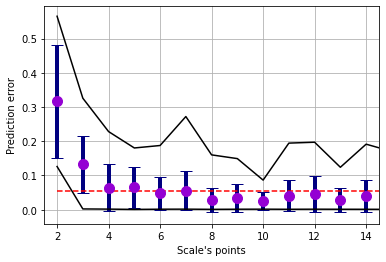

In [19]:
dn = 1
n_x = np.arange(2,max(noi_vec_b),1)

mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_x[1:]):
    j = i
    n0 = n_x[j]
    
    m1 = noi_vec_b<n1
    m2 = noi_vec_b>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec_b[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x[0:-1]

    
plt.errorbar(n_x2, mean_vec, std_vec, fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([min(n_x2),max(n_x2)],[mean_error,mean_error],'--r')

plt.xlabel("Scale's points")
plt.ylabel('Prediction error')
plt.xlim([1.5,14.5])


plt.plot(n_x2, min_vec,'k')
plt.plot(n_x2, max_vec,'k')
plt.grid()

beep()

# Distortions

In [27]:
N_pep = 200
N_bins0 = 101

# Time parameters
UNTIL_CONVERGENCE=False
T_FIXED = True
t_max = 1 # this will get multiplied by the number of people

# How many values to try
N_repetitions = 1000


noi_vec_c = []
err_vec_c = []
err2_vec_c = []

for jj in range(0, N_repetitions):
    print(jj, " out of ", N_repetitions)
    
    eps=np.random.rand()
    mu=np.random.rand()*0.5
    
    if UNTIL_CONVERGENCE:
        T = np.inf
    elif T_FIXED:
        T = N_pep*t_max
    else:
        T = N_pep*t_max*np.random.rand()
        

    x = np.array(range(N_bins0))/(N_bins0-1)

    distrib_curve = make_init_distrib(n_points_init_distrib=4, 
                                      SET_BORDERS_ZERO = False, r_smooth = 15, N_bins0 = N_bins0)

    op0 = initialize_prb(x, N_pep, distrib_curve)
    
    # Make the curve and apply it
    [dist_curve, non_linearity] = make_dist_curve(exp_min = 1/3, exp_max = 3, prb_averaging = 0.3)
    op_dist = transfor_data(op0, dist_curve, x)


    op_dist[op_dist < 0] = 0
    op_dist[op_dist > 1] = 1

    op0_2 = run_deffuant5(op0,T=T,eps=eps,mu=mu,scale=x)
    op_dist_2 = run_deffuant5(op_dist,T=T,eps=eps,mu=mu,scale=x)
    
    if to_origin_scale:
        err = get_error(op0_2,op_dist_2,x,x)
    else:
        err = 0
    
    err2 = get_error2(op0_2,op_dist_2)
    
    noi_vec_c.append(non_linearity)
    err_vec_c.append(err)
    err2_vec_c.append(err2)
    
noi_vec_c = np.array(noi_vec_c)
err_vec_c = np.array(err_vec_c)
err2_vec_c = np.array(err2_vec_c)

0  out of  1000
1  out of  1000
2  out of  1000
3  out of  1000
4  out of  1000
5  out of  1000
6  out of  1000
7  out of  1000
8  out of  1000
9  out of  1000
10  out of  1000
11  out of  1000
12  out of  1000
13  out of  1000
14  out of  1000
15  out of  1000
16  out of  1000
17  out of  1000
18  out of  1000
19  out of  1000
20  out of  1000
21  out of  1000
22  out of  1000
23  out of  1000
24  out of  1000
25  out of  1000
26  out of  1000
27  out of  1000
28  out of  1000
29  out of  1000
30  out of  1000
31  out of  1000
32  out of  1000
33  out of  1000
34  out of  1000
35  out of  1000
36  out of  1000
37  out of  1000
38  out of  1000
39  out of  1000
40  out of  1000
41  out of  1000
42  out of  1000
43  out of  1000
44  out of  1000
45  out of  1000
46  out of  1000
47  out of  1000
48  out of  1000
49  out of  1000
50  out of  1000
51  out of  1000
52  out of  1000
53  out of  1000
54  out of  1000
55  out of  1000
56  out of  1000
57  out of  1000
58  out of  1000
59  out

465  out of  1000
466  out of  1000
467  out of  1000
468  out of  1000
469  out of  1000
470  out of  1000
471  out of  1000
472  out of  1000
473  out of  1000
474  out of  1000
475  out of  1000
476  out of  1000
477  out of  1000
478  out of  1000
479  out of  1000
480  out of  1000
481  out of  1000
482  out of  1000
483  out of  1000
484  out of  1000
485  out of  1000
486  out of  1000
487  out of  1000
488  out of  1000
489  out of  1000
490  out of  1000
491  out of  1000
492  out of  1000
493  out of  1000
494  out of  1000
495  out of  1000
496  out of  1000
497  out of  1000
498  out of  1000
499  out of  1000
500  out of  1000
501  out of  1000
502  out of  1000
503  out of  1000
504  out of  1000
505  out of  1000
506  out of  1000
507  out of  1000
508  out of  1000
509  out of  1000
510  out of  1000
511  out of  1000
512  out of  1000
513  out of  1000
514  out of  1000
515  out of  1000
516  out of  1000
517  out of  1000
518  out of  1000
519  out of  1000
520  out o

921  out of  1000
922  out of  1000
923  out of  1000
924  out of  1000
925  out of  1000
926  out of  1000
927  out of  1000
928  out of  1000
929  out of  1000
930  out of  1000
931  out of  1000
932  out of  1000
933  out of  1000
934  out of  1000
935  out of  1000
936  out of  1000
937  out of  1000
938  out of  1000
939  out of  1000
940  out of  1000
941  out of  1000
942  out of  1000
943  out of  1000
944  out of  1000
945  out of  1000
946  out of  1000
947  out of  1000
948  out of  1000
949  out of  1000
950  out of  1000
951  out of  1000
952  out of  1000
953  out of  1000
954  out of  1000
955  out of  1000
956  out of  1000
957  out of  1000
958  out of  1000
959  out of  1000
960  out of  1000
961  out of  1000
962  out of  1000
963  out of  1000
964  out of  1000
965  out of  1000
966  out of  1000
967  out of  1000
968  out of  1000
969  out of  1000
970  out of  1000
971  out of  1000
972  out of  1000
973  out of  1000
974  out of  1000
975  out of  1000
976  out o

##### Plot the data

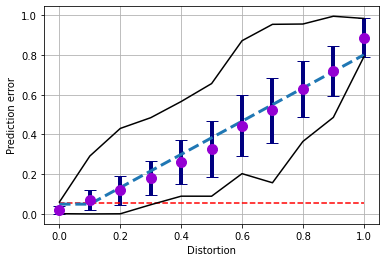

In [28]:
dn = 0.1
n_x = np.arange(0,1+dn,dn)

n_xb = (n_x[1:]+n_x[0:-1]-0.02)/2

n_xc = np.array(n_x[0])
n_xc = np.append(n_xc,n_xb)
n_xc = np.append(n_xc,np.array(n_x[-1]))


mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_xc[1:]):
    j = i
    n0 = n_xc[j]
    
    m1 = noi_vec_c<n1
    m2 = noi_vec_c>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec_c[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x
    
plt.errorbar(n_x2, mean_vec, std_vec, fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([min(n_x2),max(n_x2)],[mean_error,mean_error],'--r')
    
plt.xlabel('Distortion')
plt.ylabel('Prediction error')

plt.plot([0,0.1,1], [0.05,0.05,0.8],'--', linewidth=3)

plt.plot(n_x2, min_vec,'k')
plt.plot(n_x2, max_vec,'k')
plt.grid()

beep()

# Repeat the analysis fot the 

### Intrinsic Stochastic Error analysis

In [22]:
N_bins0 = 101

# Time parameters
UNTIL_CONVERGENCE=False
T_FIXED = False

t_max = 5 # this will get multiplied by the number of people
t_min = 0.1

N_pep_max = 1000
N_pep_min = 100

# How many values to try
N_repetitions = 1000


err_vec_d = []
err2_vec_d = []

Tr_vec = []
N_pep_vec = []
eps_vec = []
mu_vec = []

for jj in range(0, N_repetitions):
    print(jj, " out of ", N_repetitions)
    
    N_bins1 = 2+int(np.round((N_bins_test-2)*np.random.rand()))
    
    ###########################################
    N_pep = int((N_pep_max-N_pep_min)*np.random.rand()+N_pep_min)
    eps=np.random.rand()*0.5
    mu=np.random.rand()*0.5
    ###########################################
    
    if UNTIL_CONVERGENCE:
        T = np.inf
    elif T_FIXED:
        T = N_pep*(t_max+t_min)
    else:
        T = N_pep*t_max*np.random.rand()
        

    x = np.array(range(N_bins0))/(N_bins0-1)
    x2 = np.array(range(N_bins1))/(N_bins1-1)

    distrib_curve = make_init_distrib(n_points_init_distrib=4, 
                                      SET_BORDERS_ZERO = False, r_smooth = 15, N_bins0 = N_bins0)

    op0 = initialize_prb(x, N_pep, distrib_curve)

    op_dist[op_dist < 0] = 0
    op_dist[op_dist > 1] = 1

    op0_2 = run_deffuant5(op0,T=T,eps=eps,mu=mu,scale=x)
    op_dist_2 = run_deffuant5(op0,T=T,eps=eps,mu=mu,scale=x)
    
    if to_origin_scale:
        err = get_error(op0_2,op_dist_2,x,x)
    else:
        err = 0
    
    err2 = get_error2(op0_2,op_dist_2)
    
    err_vec_d.append(err)
    err2_vec_d.append(err2)
    
    Tr_vec.append(T/N_pep)
    N_pep_vec.append(N_pep)
    eps_vec.append(eps)
    mu_vec.append(mu)
    
err_vec_d = np.array(err_vec_d)
err2_vec_d = np.array(err2_vec_d)

Tr_vec = np.array(Tr_vec)
N_pep_vec = np.array(N_pep_vec)
eps_vec = np.array(eps_vec)
mu_vec = np.array(mu_vec)

0  out of  1000
1  out of  1000
2  out of  1000
3  out of  1000
4  out of  1000
5  out of  1000
6  out of  1000
7  out of  1000
8  out of  1000
9  out of  1000
10  out of  1000
11  out of  1000
12  out of  1000
13  out of  1000
14  out of  1000
15  out of  1000
16  out of  1000
17  out of  1000
18  out of  1000
19  out of  1000
20  out of  1000
21  out of  1000
22  out of  1000
23  out of  1000
24  out of  1000
25  out of  1000
26  out of  1000
27  out of  1000
28  out of  1000
29  out of  1000
30  out of  1000
31  out of  1000
32  out of  1000
33  out of  1000
34  out of  1000
35  out of  1000
36  out of  1000
37  out of  1000
38  out of  1000
39  out of  1000
40  out of  1000
41  out of  1000
42  out of  1000
43  out of  1000
44  out of  1000
45  out of  1000
46  out of  1000
47  out of  1000
48  out of  1000
49  out of  1000
50  out of  1000
51  out of  1000
52  out of  1000
53  out of  1000
54  out of  1000
55  out of  1000
56  out of  1000
57  out of  1000
58  out of  1000
59  out

462  out of  1000
463  out of  1000
464  out of  1000
465  out of  1000
466  out of  1000
467  out of  1000
468  out of  1000
469  out of  1000
470  out of  1000
471  out of  1000
472  out of  1000
473  out of  1000
474  out of  1000
475  out of  1000
476  out of  1000
477  out of  1000
478  out of  1000
479  out of  1000
480  out of  1000
481  out of  1000
482  out of  1000
483  out of  1000
484  out of  1000
485  out of  1000
486  out of  1000
487  out of  1000
488  out of  1000
489  out of  1000
490  out of  1000
491  out of  1000
492  out of  1000
493  out of  1000
494  out of  1000
495  out of  1000
496  out of  1000
497  out of  1000
498  out of  1000
499  out of  1000
500  out of  1000
501  out of  1000
502  out of  1000
503  out of  1000
504  out of  1000
505  out of  1000
506  out of  1000
507  out of  1000
508  out of  1000
509  out of  1000
510  out of  1000
511  out of  1000
512  out of  1000
513  out of  1000
514  out of  1000
515  out of  1000
516  out of  1000
517  out o

919  out of  1000
920  out of  1000
921  out of  1000
922  out of  1000
923  out of  1000
924  out of  1000
925  out of  1000
926  out of  1000
927  out of  1000
928  out of  1000
929  out of  1000
930  out of  1000
931  out of  1000
932  out of  1000
933  out of  1000
934  out of  1000
935  out of  1000
936  out of  1000
937  out of  1000
938  out of  1000
939  out of  1000
940  out of  1000
941  out of  1000
942  out of  1000
943  out of  1000
944  out of  1000
945  out of  1000
946  out of  1000
947  out of  1000
948  out of  1000
949  out of  1000
950  out of  1000
951  out of  1000
952  out of  1000
953  out of  1000
954  out of  1000
955  out of  1000
956  out of  1000
957  out of  1000
958  out of  1000
959  out of  1000
960  out of  1000
961  out of  1000
962  out of  1000
963  out of  1000
964  out of  1000
965  out of  1000
966  out of  1000
967  out of  1000
968  out of  1000
969  out of  1000
970  out of  1000
971  out of  1000
972  out of  1000
973  out of  1000
974  out o

#### Plot Tr

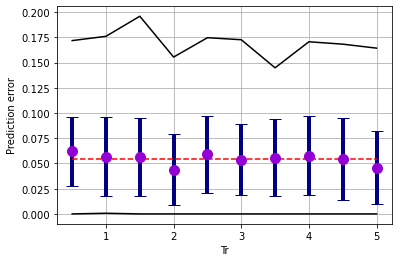

In [23]:
dn = 0.5
n_x = np.arange(0,5+dn,dn)

noi_vec_T = Tr_vec

n_xb = (n_x[1:]+n_x[0:-1])/2

n_xc = np.array(n_x[0])
n_xc = np.append(n_xc,n_xb)
n_xc = np.append(n_xc,np.array(n_x[-1]))


mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_xc[1:]):
    j = i
    n0 = n_xc[j]
    
    m1 = noi_vec_T<n1
    m2 = noi_vec_T>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec_d[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x
    
plt.errorbar(n_x2[1:], mean_vec[1:], std_vec[1:], fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([n_x2[1],max(n_x2)],[mean_error,mean_error],'--r')
plt.ylabel('Prediction error')
    

plt.xlabel('Tr')

plt.plot(n_x2[1:], min_vec[1:],'k')
plt.plot(n_x2[1:], max_vec[1:],'k')
plt.grid()

#### Plot N_pep

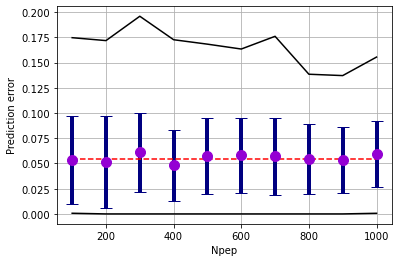

In [24]:
dn = 100
n_x = np.arange(100,1000+dn,dn)

noi_vec_T = N_pep_vec

n_xb = (n_x[1:]+n_x[0:-1])/2

n_xc = np.array(n_x[0])
n_xc = np.append(n_xc,n_xb)
n_xc = np.append(n_xc,np.array(n_x[-1]))


mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_xc[1:]):
    j = i
    n0 = n_xc[j]
    
    m1 = noi_vec_T<n1
    m2 = noi_vec_T>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec_d[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x
    

plt.errorbar(n_x2, mean_vec, std_vec, fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([min(n_x2),max(n_x2)],[mean_error,mean_error],'--r')
plt.ylabel('Prediction error')
    

plt.xlabel('Npep')

plt.plot(n_x2, min_vec,'k')
plt.plot(n_x2, max_vec,'k')
plt.grid()

#### Plot Eps

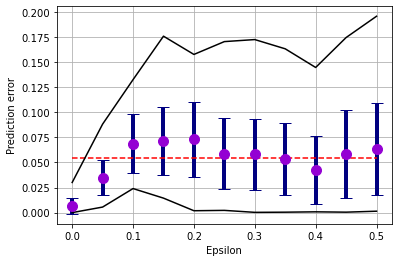

In [25]:
dn = 0.05
n_x = np.arange(0,0.5+dn,dn)

noi_vec_T = eps_vec

n_xb = (n_x[1:]+n_x[0:-1])/2

n_xc = np.array(n_x[0])
n_xc = np.append(n_xc,n_xb)
n_xc = np.append(n_xc,np.array(n_x[-1]))


mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_xc[1:]):
    j = i
    n0 = n_xc[j]
    
    m1 = noi_vec_T<n1
    m2 = noi_vec_T>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec_d[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x
    
plt.errorbar(n_x2, mean_vec, std_vec, fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([min(n_x2),max(n_x2)],[mean_error,mean_error],'--r')

plt.ylabel('Prediction error')
plt.xlabel('Epsilon')

plt.plot(n_x2, min_vec,'k')
plt.plot(n_x2, max_vec,'k')
plt.grid()

#### Plot Mu

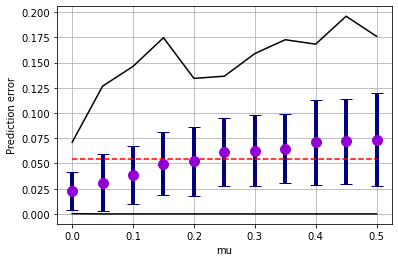

In [26]:
dn = 0.05
n_x = np.arange(0,0.5+dn,dn)

noi_vec_T = mu_vec

n_xb = (n_x[1:]+n_x[0:-1])/2

n_xc = np.array(n_x[0])
n_xc = np.append(n_xc,n_xb)
n_xc = np.append(n_xc,np.array(n_x[-1]))


mean_vec = []
std_vec = []
min_vec = []
max_vec = []

for i, n1 in enumerate(n_xc[1:]):
    j = i
    n0 = n_xc[j]
    
    m1 = noi_vec_T<n1
    m2 = noi_vec_T>=n0
    
    m = np.logical_and(m1,m2)
    
    nn = err2_vec_d[m]
    
    mean = np.mean(nn)
    std = np.std(nn)
    min_ = np.min(nn)
    max_ = np.max(nn)
    
    mean_vec.append(mean)
    std_vec.append(std)
    min_vec.append(min_)
    max_vec.append(max_)
    
n_x2 = n_x
    
plt.errorbar(n_x2, mean_vec, std_vec, fmt='o', ecolor='navy',color='darkviolet',
             linewidth=4,capsize=6, markersize=10)

plt.plot([min(n_x2),max(n_x2)],[mean_error,mean_error],'--r')
plt.ylabel('Prediction error')
plt.xlabel('mu')
plt.plot(n_x2, min_vec,'k')
plt.plot(n_x2, max_vec,'k')

plt.grid()